## E-commerce customer **Repurchase behavior** analysis
### `Seminar in Statistics` class Mid-term personal project by. `20175972 최수연`
- (Note) 이 코드는 kaggle notebook에서 작성하였습니다 :)
- kaggle dataset URL: https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store/code

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv
/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv
/kaggle/input/train-data/suyeon_data.csv


In [2]:
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as dates
from datetime import datetime

%matplotlib inline

주어진 데이터셋은 2019년 10, 11월의 이커머스 판매 데이터이다.  
먼저 2019년 10월 데이터를 읽어와 사전분석(EDA)를 진행하고, 어떤 특징을 보이는지 알아보았다.

In [4]:
#2019년 10월 데이터 읽어오기
df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [6]:
df.shape

(42448764, 9)

In [7]:
df.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [8]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

데이터 'df'는 약 424만개의 데이터셋이 있으며, category_code, brand에서 다수의 결측치가 있고 user_session엔 2개의 결측치가 존재한다. 먼저, user_session의 결측치를 제거한다.

In [5]:
df = df[df['user_session'].notnull()]
df.isna().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            0
dtype: int64

In [10]:
#가장 많은 category_code에서의 결측치 비율 
df['category_code'].isna().sum() / len(df)

0.31839819026995414

이제 결측치는 category_code, brand에만 존재한다. 각각 약 135만개, 61만개 씩의 결측치가 있으며, 이는 전체 데이터 대비 category_code는 약 32%의 결측치가 존재한다.  
category_code에 대응하는 category_id는 결측치가 없으나, 데이터 description으로 category_id가 어떤 값인지 나와 있지 않다.  
따라서 *category_code* 를 살리는 방향으로 가되, 만일 category_code 값이 있는데도 누락되어 NaN이 된 거라면, 이를 채워주는 작업을 진행하였다.

In [6]:
#먼저 category_code의 결측값이 없는 것을 뽑아, category_code와 category_id 의 사전을 만들어보자.
df2 = df[df['category_code'].notnull()]
df2[['category_code','category_id']]

,category_code,category_id
1,appliances.environment.water_heater,2053013552326770905
2,furniture.living_room.sofa,2053013559792632471
3,computers.notebook,2053013558920217191
4,electronics.smartphone,2053013555631882655
5,computers.desktop,2053013561092866779
...,...,...
42448757,electronics.smartphone,2053013555631882655
42448758,appliances.kitchen.refrigerators,2053013563911439225
42448759,electronics.camera.video,2053013560530830019
42448761,auto.accessories.player,2053013553970938175


In [11]:
#그리고 category_id와 category_code가 1:1 대응하는지를 판단한다.
df2.groupby('category_id')['category_code'].nunique().value_counts() #전부 1인 것 뿐이므로 code와 id는 1:1 대응한다.

1    252
Name: category_code, dtype: int64

In [12]:
#df2로 사전을 만든다.
## key:value = category_id: category_code
cate_dict = dict(zip(df2['category_id'], df2['category_code']))

In [13]:
# 아까 만든 사전 cate_dict에서 category_code에 결측치가 있을 때의 category_id가 존재하는지 판단한다.
res = 0
for cate_id in df[df['category_code'].isna()]['category_id']:
    if cate_id in cate_dict:
        res+=1
res #res는 0으로, 존재하지 않는다.

0

In [7]:
del df2

아쉽게도 category_id : category_code가 1:1 대응하는 사전을 만들어 category_code의 결측치를 채워주려 하였지만, 이 결측치에 해당하는 category_id가 없어 채우지 못하였다.  
그래도 category_code는 어떤 카테고리인지 유의한 변수이므로, 결측값이 아닌 나머지 70%만 살리고 가져가기로 하였다.

### Data Description
1. event_time : 각 event가 발생한 시간(UTC 기준)
1. event_type : event의 타입. view, cart, remove_from_cart, purchase로 구분
1. product_id : 상품 id
1. category_id : 상품 카테고리 id 
1. category_code : 카테고리 id에 대응하는 카테고리가 무엇인지(문자). **결측치 다수 존재**
1. brand : 상품의 brand name. **결측치 다수 존재**
1. price : 상품의 가격
1. user_id : 영구적인 user id
1. *user_session* : 일시적인 user session id. 각 유저의 session마다 동일하고, 접속 후 오랫동안 안들어오다가 다시 들어오면 다른 user session이 부여된다. 

## EDA
데이터를 만져보면서 이 데이터만의 특이점엔 무엇이 있는지 알아본다.

In [11]:
#유니크한 유저만 세기: 총 unique user는 약 302만 명이다.
df['user_id'].nunique()

3022290

In [12]:
#user_id별 현황 -> 1인 게 많다.
df.value_counts('user_id')

user_id
512475445    7436
512365995    4013
526731152    2912
512505687    2894
513021392    2862
             ... 
547814402       1
547814510       1
547814521       1
547814622       1
33869381        1
Length: 3022290, dtype: int64

In [13]:
#user_id가 딱 1번만 등장한 것이 69만 건, 나머지는 233만 건(여러 번 들어온 유저의 unique id)
(df.groupby('user_id')['user_id'].count() == 1).value_counts()

False    2331044
True      691246
Name: user_id, dtype: int64

#### 초회 이용자 패턴 파악하기
단 1번만 들어온 user_id만 골라, 어떤 행동을 했는지 알아봄 

In [14]:
user_count = df.groupby('user_id')['user_id'].count()
user_count = user_count[user_count == 1]
first = user_count.index.tolist()

#단 38명만 접속후 곧바로 구입(pusrchase)하였으며, 들어와서 보고(view)만 나간 유저가 대다수.
df.query('user_id in @first')['event_type'].value_counts()

view        691137
cart            71
purchase        38
Name: event_type, dtype: int64

이번엔 전체 유저를 대상으로, 어느 시기에 많이 구입했는지 알아보자.

In [15]:
#유저별 event_time 알아보기
d = df.loc[:, ['event_time', 'user_id']]
#event_time의 연월일만 잘라내기
d['event_time'] = d['event_time'].apply(lambda s: str(s)[:10])
d.head()

,event_time,user_id
0,2019-10-01,541312140
1,2019-10-01,554748717
2,2019-10-01,519107250
3,2019-10-01,550050854
4,2019-10-01,535871217


In [16]:
#만일 중복 데이터가 있다면, 제거하고 event_time별로 그룹바이
#즉, event_time의 연월일별 이용한 유저는 몇 명이나 카운트되는가?
visitor_by_date = d.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
visitor_by_date[:10]

,count
event_time,
2019-10-01,190188
2019-10-02,184965
2019-10-03,170668
2019-10-04,209410
2019-10-05,194958
2019-10-06,193210
2019-10-07,186951
2019-10-08,221204
2019-10-09,214140


In [17]:
del d

#### 방문자수의 추이

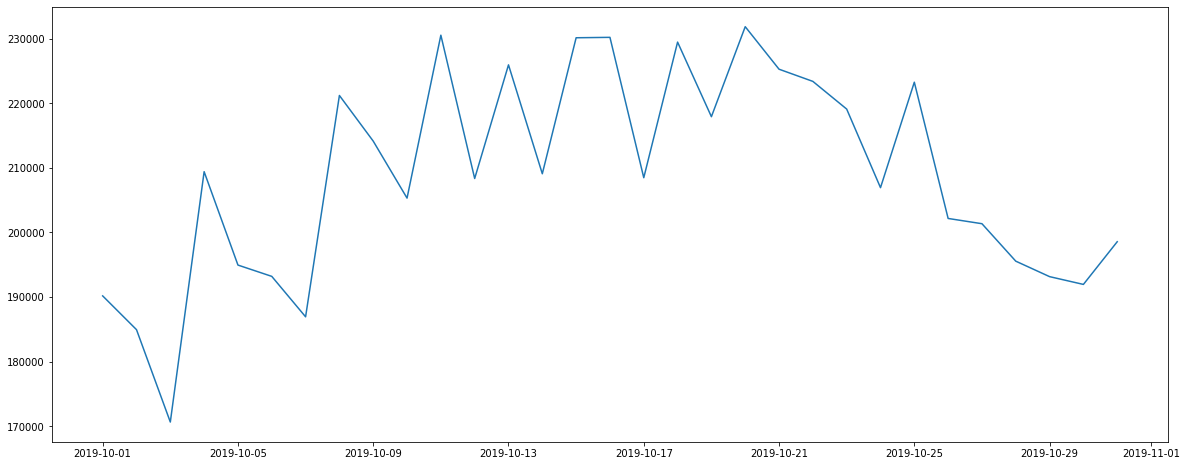

In [18]:
#위 결과를 그래프로 나타내보기!
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show() #10월 중순에 가장 많이 방문하는 것을 알 수 있음! 

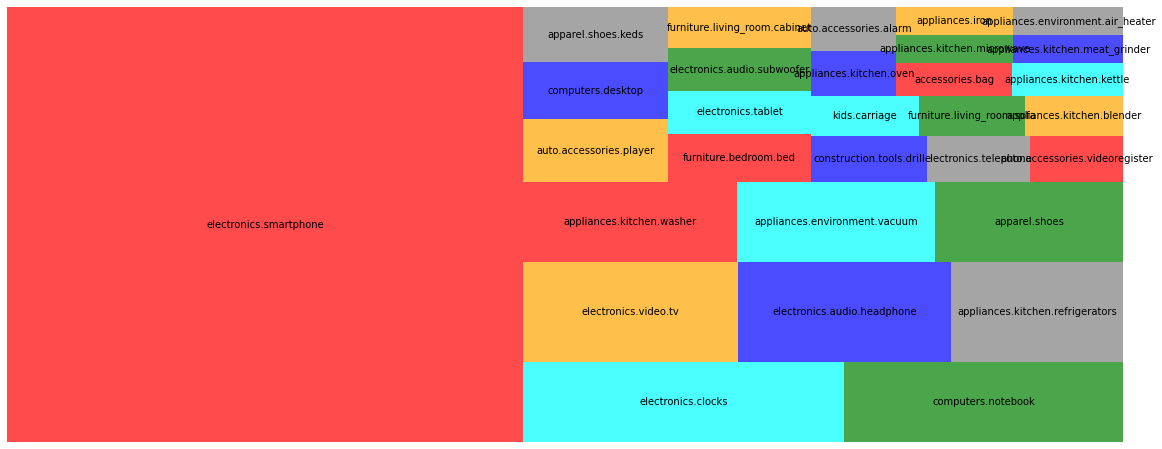

In [19]:
# 10월 한달 동안, 어떤 카테고리를 고객이 가장 많이 보았는지 알아보기 
top_category_n = 30
top_category = df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

In [20]:
# 이번엔 유저의 event_type 별로 알아보기 
df['event_type'].value_counts()

view        40779399
cart          926514
purchase      742849
Name: event_type, dtype: int64

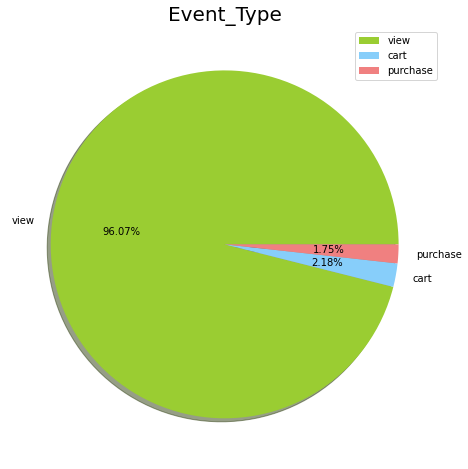

In [21]:
labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

가장 많이 본 카테고리는 smartphone이며,  
event_type은 view가 96%로 대부분을 차지하며 cart와 purchase는 약 2%씩이다.

그럼 purchase로 가장 많이 이어진 category_code와 brand는 무엇일까?

In [22]:
purchase = df.loc[df['event_type'] == 'purchase']
purchase = purchase.dropna(axis='rows') #결측치 제거 
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
574,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
603,2019-10-01 00:09:54 UTC,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68


In [23]:
purchase.groupby('category_code')['event_type'].agg(['count']).sort_values(by = 'count', ascending=False)

,count
category_code,
electronics.smartphone,337575
electronics.audio.headphone,30439
electronics.video.tv,21548
electronics.clocks,16647
appliances.kitchen.washer,16059
...,...
apparel.jeans,3
apparel.skirt,3
apparel.shorts,2


In [24]:
top_sellers = purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
top_sellers.head(20)

,count
brand,
samsung,171706
apple,142577
xiaomi,46595
huawei,23294
oppo,10891
lg,7831
acer,6882
elenberg,5435
indesit,5023


결과를 보면, 구매(purchase)로 이어진 것 중 가장 많은 category는 smartphone을 비롯한 전자제품이 대다수이며,  
구매로 이어진 가장 많은 brand는 category와 비슷하게 삼성, 애플, 샤오미였다.

## Modeling Overview - Customer Repurchase behavior analysis
이 이커머스 데이터를 바탕으로, **고객이 구입을 할지 안 할지를 예측하는 분석**을 진행해보기로 하였다.  
하지만 피처 생성을 위해 좀 더 주제를 구체적으로 정할 필요가 있어, **구매 이력이 있는 고객을 대상으로, 재구매를 할 것인지를 예측하는 분석(Repurchase Behavior analysis)** 을 진행해보기로 결정했다.  

즉, **cart에 넣은 고객 데이터을 대상**으로, 이것이 purchase로 이어졌는지 아닌지를 예측하는 모델링을 진행해보았다.  
그 이유는 앞서 view가 데이터의 96%이고, cart와 purchase는 각각 약 2%로 둘을 연관시키는 것이 더 맞다고 판단하였기 때문이다.  
또한 **어떤 것이 재구매에 영향을 미치는지 피처의 중요도를 파악해 보고, purchase로 이어진 고객은 아닌 고객에 비해 어떤 특성이 두드러지는지** 알아보았다.  

그리고 모델링을 위한 새로운 feature 발굴을 진행하였다.

### Feature Engineering
<기존에 제공된 feature>
- event_type : cart, purchase만 필터링 (전체 데이터의 4%)
- product_id, brand
- price
- category_id, category_code
- user_id
- user_session  

<새로 발굴할 feature> 
- *activity_count* : 그 session 내 activity의 수 --> 원본 df의 user_session 카운트
- event_weekday : event_time의 weekday(요일)
- event_week : event_time의 week(주차)
- *cart_num* : user_id 및 product_id별 cart를 클릭한 횟수(같은 유저가 같은 상품을 몇 번이나 cart에 담았는가?)
- *pur_num* : user_id별 구매 횟수
- *cycle* : 구매주기로, user_id별 (최근구매일-최초구매일)/(구매횟수-1) 이며 구매횟수가 2 이상이 아니면 삭제
- category_code_1 : category
- category_code_2 : sub-category
- **is_purchased(target)** : cart에 넣었던 것이 purchase로 이어졌는지. 즉, purchase로 이어졌다면 1, 아니면 0

### Basic Operation
먼저 event_type이 cart, purchase 인 것으로만 추출한 후, purchase로 이어졌다면 'is_purchased' 컬럼을 1, 아니면 0으로 만든다.  
- purchase로 이어졌는지의 판단:   
1. event_type이 purchase이면 이어졌다고 판단 -> is_purchased를 1로 함
2. event_type이 cart더라도, 동일한 user_session에서 purchase가 있는 경우(즉, is_purchased가 1인 행이 있는 경우)는 이어졌다고 판단 -> is_purchased를 1로 함

이렇게 하여 event_type이 cart인 것만 남기고(중복 제거 후), is_purchased가 1인지 0인지 예측하는 모델링을 진행한다.

In [8]:
#새로 만들 데이터셋은 'df_targets'로 이름 붙인다.
#우선, event_type이 cart, purchase인 것만 추출 
df_targets = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
#event_type이 purchase이면 'is_purchased'를 1, 아니면 0으로 구성 
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1
331,2019-10-01 00:05:14 UTC,cart,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae,0
379,2019-10-01 00:06:02 UTC,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,1
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1


In [9]:
#event_type이 purchase인 것 뿐 아니라, user_session별 구매로 이어졌다면 is_purchased를 1, 아니면 0
##즉, 동일한 user_session과 product_id 하에서 cart로 담았다가도 session 안에 결국 purchase로 이어졌다면, is_purchased를 1로 함 
df_targets["is_purchased"] = df_targets.groupby(["user_session"])["is_purchased"].transform("max")

In [10]:
#event_time의 요일도 새로운 변수로 발굴 
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))

In [11]:
#event_time의 '주'도 새로운 변수로 발굴 
df_targets['event_time'] = pd.to_datetime(df_targets['event_time'])
df_targets['event_week'] = df_targets['event_time'].dt.strftime("%V").astype(int)-39

In [12]:
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week
162,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1
308,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1
331,2019-10-01 00:05:14+00:00,cart,5100816,2053013553375346967,NaN,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae,0,1,1
379,2019-10-01 00:06:02+00:00,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,1,1,1
442,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1


In [13]:
df_targets.isna().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    238124
brand             68236
price                 0
user_id               0
user_session          0
is_purchased          0
event_weekday         0
event_week            0
dtype: int64

In [14]:
#df_targets의 결측치 제거
df_targets.dropna(how='any', inplace=True)
df_targets.isna().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
is_purchased     0
event_weekday    0
event_week       0
dtype: int64

In [15]:
df_targets.shape

(1054871, 12)

In [16]:
#category_code에 카테고리가 섞여 있으므로 '.' 기준으로 split
df_targets["category_code_level1"] = df_targets["category_code"].str.split(".",expand=True)[0].astype('category')
df_targets["category_code_level2"] = df_targets["category_code"].str.split(".",expand=True)[1].astype('category')
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2
162,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1,electronics,smartphone
308,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,smartphone
442,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1,furniture,bathroom
574,2019-10-01 00:09:26+00:00,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,1,1,1,electronics,audio
583,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,1,1,electronics,smartphone


#### cart_num
df_targets 데이터에서 user_id & product_id별 그룹바이를 통해, cart에 담은 횟수 구함.  
- cart_num: 개인별로 어떤 product를 몇 번 cart에 넣었는지가 구매여부에 영향을 줄 거라고 생각하여 만든 피처

In [17]:
df_cart = df_targets[df_targets['event_type']=='cart'].loc[:, ['user_id','event_type','product_id']]
a = pd.DataFrame(df_cart.groupby(by=['user_id','product_id'])['event_type'].count()).reset_index()
a.rename(columns = {'event_type':'cart_num'}, inplace=True)
a.head()

,user_id,product_id,cart_num
0,284344819,1005122,1
1,293957954,1004741,1
2,304325717,1004723,1
3,318611205,1005003,1
4,318611205,17800718,1


In [18]:
df_targets = pd.merge(df_targets, a, on = ['user_id','product_id'], how='left')

In [19]:
#cart_num 값이 NaN인 것을 0으로 채우기 
df_targets['cart_num'] = df_targets['cart_num'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num
0,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1,electronics,smartphone,13.0
1,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,smartphone,0.0
2,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1,furniture,bathroom,0.0
3,2019-10-01 00:09:26+00:00,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,1,1,1,electronics,audio,0.0
4,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,1,1,electronics,smartphone,1.0


In [20]:
df_targets.shape

(1054871, 15)

#### pur_num
user_id별 구매 횟수

#### cycle
구매주기= user_id별 (최근구매-최초구매일(단위:일)/(구매횟수-1) --> 구매횟수 2 이상인 것만 걸러야함, 그렇지 않은건 0으로 채우고 삭제

In [21]:
df_cycle = df_targets[df_targets['event_type']=='purchase'].loc[:, ['event_time','event_type','user_id']]

In [22]:
#유저별 구매횟수 
n_pur = pd.DataFrame(df_cycle.groupby(by='user_id')['event_type'].count()).reset_index()
n_pur.rename(columns = {'event_type':'pur_num'}, inplace=True)
n_pur.head()

,user_id,pur_num
0,303160429,1
1,340041246,1
2,384989212,1
3,401021311,1
4,403013066,2


In [23]:
df_targets = pd.merge(df_targets, n_pur, on = ['user_id'], how='left')

In [24]:
#결측값 처리
df_targets['pur_num'] = df_targets['pur_num'].fillna(0)
#pur_num 컬럼이 2 이상이 아니면 0으로 쓰는 새로운 컬럼 생성 
df_targets['pur_num2'] = df_targets['pur_num'].apply(lambda x: x if x>=2 else 0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num,pur_num2
0,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1,electronics,smartphone,13.0,33.0,33.0
1,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,smartphone,0.0,14.0,14.0
2,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1,furniture,bathroom,0.0,4.0,4.0
3,2019-10-01 00:09:26+00:00,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,1,1,1,electronics,audio,0.0,1.0,0.0
4,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,1,1,electronics,smartphone,1.0,2.0,2.0


In [25]:
#구매횟수 컬럼 중 0인 것이 약 48만 개, 이들에 대해서는 구매주기 피처를 구할 수 없으므로 모두 제거
df_targets['pur_num2'].value_counts()

0.0     479674
2.0     166539
3.0      90511
4.0      58789
5.0      39377
         ...  
72.0       102
73.0        97
66.0        97
82.0        91
71.0        88
Name: pur_num2, Length: 99, dtype: int64

In [26]:
df_targets = df_targets[df_targets['pur_num2']>0]
df_targets.shape #약 58만 개로 데이터 감소 

(575197, 17)

In [27]:
#구매횟수 - 1을 구해야 하므로 새로운 컬럼 pur_num3 생성
df_targets['pur_num3'] = df_targets['pur_num2'] - 1
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num,pur_num2,pur_num3
0,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1,electronics,smartphone,13.0,33.0,33.0,32.0
1,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,smartphone,0.0,14.0,14.0,13.0
2,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1,furniture,bathroom,0.0,4.0,4.0,3.0
4,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,1,1,electronics,smartphone,1.0,2.0,2.0,1.0
5,2019-10-01 00:09:54+00:00,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,audio,0.0,14.0,14.0,13.0


In [28]:
#유저별 최근, 최초구매일 
cycle2 = df_cycle.groupby(by='user_id')['event_time'].agg(['min','max'])
cycle2.reset_index(inplace=True)
cycle2['diff'] = cycle2['max']-cycle2['min']
cycle2['diff2'] = cycle2['diff'].dt.days #시간차(단위: 일) 로 변환 
cycle2.head()

,user_id,min,max,diff,diff2
0,303160429,2019-10-13 13:25:29+00:00,2019-10-13 13:25:29+00:00,0 days 00:00:00,0
1,340041246,2019-10-14 14:45:39+00:00,2019-10-14 14:45:39+00:00,0 days 00:00:00,0
2,384989212,2019-10-18 11:19:59+00:00,2019-10-18 11:19:59+00:00,0 days 00:00:00,0
3,401021311,2019-10-21 04:19:14+00:00,2019-10-21 04:19:14+00:00,0 days 00:00:00,0
4,403013066,2019-10-18 19:07:54+00:00,2019-10-18 19:15:13+00:00,0 days 00:07:19,0


In [29]:
#diff2 컬럼만 남기고 삭제
cycle2.drop(['min','max','diff'], axis=1, inplace=True)
#merge
df_targets = pd.merge(df_targets, cycle2, on=['user_id'], how='left')
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num,pur_num2,pur_num3,diff2
0,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1,electronics,smartphone,13.0,33.0,33.0,32.0,30
1,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,smartphone,0.0,14.0,14.0,13.0,24
2,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1,furniture,bathroom,0.0,4.0,4.0,3.0,26
3,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,1,1,electronics,smartphone,1.0,2.0,2.0,1.0,7
4,2019-10-01 00:09:54+00:00,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,audio,0.0,14.0,14.0,13.0,24


In [30]:
#구매주기(cycle) 컬럼 생성
df_targets['cycle'] = df_targets['diff2']/df_targets['pur_num3']
df_targets

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num,pur_num2,pur_num3,diff2,cycle
0,2019-10-01 00:02:14+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1,1,1,electronics,smartphone,13.0,33.0,33.0,32.0,30,0.937500
1,2019-10-01 00:04:37+00:00,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,smartphone,0.0,14.0,14.0,13.0,24,1.846154
2,2019-10-01 00:07:07+00:00,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1,1,1,furniture,bathroom,0.0,4.0,4.0,3.0,26,8.666667
3,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,1,1,electronics,smartphone,1.0,2.0,2.0,1.0,7,7.000000
4,2019-10-01 00:09:54+00:00,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,1,1,1,electronics,audio,0.0,14.0,14.0,13.0,24,1.846154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575192,2019-10-31 23:55:21+00:00,purchase,47500017,2110937143172923797,construction.tools.light,puckator,20.59,514622109,5724116e-365b-4ac1-9d03-b8d66e1ccc7c,1,3,5,construction,tools,0.0,2.0,2.0,1.0,22,22.000000
575193,2019-10-31 23:56:03+00:00,purchase,1003306,2053013555631882655,electronics.smartphone,apple,577.89,512717356,f35ac37c-9573-4e30-b3d9-c09bb0b95a2b,1,3,5,electronics,smartphone,4.0,4.0,4.0,3.0,25,8.333333
575194,2019-10-31 23:56:11+00:00,cart,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,1,3,5,electronics,smartphone,1.0,6.0,6.0,5.0,17,3.400000
575195,2019-10-31 23:56:53+00:00,purchase,1004240,2053013555631882655,electronics.smartphone,apple,1054.60,533892594,3a5a3b01-2ab1-4a1d-a202-30d336e0057b,1,3,5,electronics,smartphone,1.0,6.0,6.0,5.0,17,3.400000


### cart에 담은 고객만을 대상으로, 중복 제거 작업
앞에서 is_purchased 컬럼은 완성되었다. 꼭 event_type이 purchase가 아니더라도 purchase로 나중에 이어졌다면 cart도 포함하였다.  
현재 원하는 것은 **구매이력이 있는 고객을 대상으로, 재구매여부를 예측하는 모델링** 이므로, cart에 담은 데이터만을 대상으로 이것이 결국 purchase로 이어질지?(is_purchased==1)를 예측하는 것이다.  
그러니 event_type이 cart인 것으로만 거르고, **여기서 동일한 session에서 동일한 상품을 cart에 담는 것은 중복으로 여기고 제거**한다.

In [31]:
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets.shape #데이터는 약 24만 개로 감소.

(242273, 20)

이제 모델링을 위한 train set이 거의 만들어졌다!  
마지막으로 그 session 내의 activity 수를 카운트하는 'activity_count'피처를 생성해보자.

#### activity_count
원본 df에서 user_session별로 event_type 개수를 새로운 컬럼 *'activity_count'*로 한다.  
**즉, 한 user_session에서 view, cart, purchase 등의 event 활동을 몇 번이나 클릭했는가? 를 의미함!**

In [32]:
#먼저, 원본 데이터인 df에서 cart와 purchase가 있는 것을 뽑고, user_id가 중복된 것을 제거 
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
#결측치 제거 
cart_purchase_users.dropna(how='any', inplace=True)
#결측치 제거한 user_id가 겹치는 것을 원본 df에서 추출
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]

In [33]:
cart_purchase_users_all_activity.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
5,2019-10-01 00:00:05 UTC,view,1480613,2053013561092866779,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
22,2019-10-01 00:00:22 UTC,view,1480714,2053013561092866779,computers.desktop,pulser,921.49,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
23,2019-10-01 00:00:23 UTC,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,197.55,519530528,9882d21f-2c5f-496b-90d4-a1503edb6562
28,2019-10-01 00:00:25 UTC,view,27500014,2053013554692358509,NaN,redmond,37.98,555217733,74d40a28-41f9-4325-bbae-b179bd2c0a38
36,2019-10-01 00:00:28 UTC,view,28714755,2053013565228450757,apparel.shoes,respect,51.22,555447570,99877fbe-d5a8-475e-a662-66bc9d29b6f8


In [34]:
#동일한 user_session별로 그룹바이 -> activity_count 생성, 인덱스 reset 
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
#이름 변경 
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})
activity_in_session

,user_session,activity_count
0,00000083-8816-4d58-a9b8-f52f54186edc,18
1,000001fd-1f89-45e8-a3ce-fe3218cabfad,11
2,000003eb-b63e-45d9-9f26-f229057c654a,1
3,00000809-9101-4e4b-9795-e6cbafccfe19,4
4,00000aaa-d774-49bc-9c31-0c9f6e1c2f0a,1
...,...,...
2331286,ffffd6fe-a5c3-4c9e-bc57-8d7601521cc0,2
2331287,ffffd89d-208c-28ec-da2f-6668c878fffc,1
2331288,ffffdf58-84cb-4337-a802-061db4843e54,1
2331289,ffffe3ba-7c09-4c3a-a8fe-75ba46b1e146,2


In [35]:
#위에서 만든 'activity_count' 열을 새로운 컬럼으로 생성 
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
#user_session 값이 없는 activity_count는 0으로 채움 
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,...,event_week,category_code_level1,category_code_level2,cart_num,pur_num,pur_num2,pur_num3,diff2,cycle,activity_count
0,2019-10-01 00:09:33+00:00,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1,...,1,electronics,smartphone,1.0,2.0,2.0,1.0,7,7.000000,4.0
1,2019-10-01 00:11:00+00:00,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,1,...,1,electronics,audio,4.0,4.0,4.0,3.0,19,6.333333,4.0
2,2019-10-01 02:19:36+00:00,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,1,...,1,electronics,smartphone,1.0,3.0,3.0,2.0,7,3.500000,16.0
3,2019-10-01 02:19:43+00:00,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,1,...,1,electronics,smartphone,2.0,8.0,8.0,7.0,23,3.285714,10.0
4,2019-10-01 02:21:49+00:00,cart,5100719,2053013553341792533,electronics.clocks,samsung,151.61,549614436,129d379f-0137-4bd5-bf30-90c4c7bef7c8,1,...,1,electronics,clocks,1.0,2.0,2.0,1.0,23,23.000000,7.0


In [36]:
df_targets.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'is_purchased', 'event_weekday', 'event_week', 'category_code_level1',
       'category_code_level2', 'cart_num', 'pur_num', 'pur_num2', 'pur_num3',
       'diff2', 'cycle', 'activity_count'],
      dtype='object')

In [37]:
#불필요한 컬럼 삭제
df_targets.drop(['event_type','user_id','user_session','pur_num','pur_num3','diff2'], axis=1, inplace=True)
df_targets.head()

,event_time,product_id,category_id,category_code,brand,price,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num2,cycle,activity_count
0,2019-10-01 00:09:33+00:00,1002524,2053013555631882655,electronics.smartphone,apple,515.67,1,1,1,electronics,smartphone,1.0,2.0,7.000000,4.0
1,2019-10-01 00:11:00+00:00,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,1,1,1,electronics,audio,4.0,4.0,6.333333,4.0
2,2019-10-01 02:19:36+00:00,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,1,1,1,electronics,smartphone,1.0,3.0,3.500000,16.0
3,2019-10-01 02:19:43+00:00,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,1,1,1,electronics,smartphone,2.0,8.0,3.285714,10.0
4,2019-10-01 02:21:49+00:00,5100719,2053013553341792533,electronics.clocks,samsung,151.61,1,1,1,electronics,clocks,1.0,2.0,23.000000,7.0


In [38]:
df_targets.shape #최종 모델링에 쓰일 데이터: 24만 개!

(242273, 15)

In [ ]:
#미리 저장해두기 -> top-right 위치한 output에서 다운로드
df_targets.to_csv('suyeon_data.csv')

### 새로운 dataset 사용 & Model 구축

In [39]:
# 저장한 데이터셋 불러오기
df_targets = pd.read_csv('/kaggle/input/train-data/suyeon_data.csv', engine='python')
df_targets.head()

,Unnamed: 0,event_time,product_id,category_id,category_code,brand,price,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num2,cycle,activity_count
0,0,2019-10-01 00:09:33+00:00,1002524,2053013555631882655,electronics.smartphone,apple,515.67,1,1,1,electronics,smartphone,1.0,2.0,7.000000,4.0
1,1,2019-10-01 00:11:00+00:00,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,1,1,1,electronics,audio,4.0,4.0,6.333333,4.0
2,2,2019-10-01 02:19:36+00:00,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,1,1,1,electronics,smartphone,1.0,3.0,3.500000,16.0
3,3,2019-10-01 02:19:43+00:00,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,1,1,1,electronics,smartphone,2.0,8.0,3.285714,10.0
4,4,2019-10-01 02:21:49+00:00,5100719,2053013553341792533,electronics.clocks,samsung,151.61,1,1,1,electronics,clocks,1.0,2.0,23.000000,7.0


In [40]:
#불필요한 컬럼 제거
df_targets.drop('Unnamed: 0',axis=1, inplace=True)
#shape 확인
print(df_targets.shape)
#변수들 확인
print(df_targets.columns)

(242273, 15)
Index(['event_time', 'product_id', 'category_id', 'category_code', 'brand',
       'price', 'is_purchased', 'event_weekday', 'event_week',
       'category_code_level1', 'category_code_level2', 'cart_num', 'pur_num2',
       'cycle', 'activity_count'],
      dtype='object')


원본 424만개의 데이터에서, 현재 모델링에 쓸 training data는 약 24만 개로 줄여졌다.

In [41]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242273 entries, 0 to 242272
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   event_time            242273 non-null  object 
 1   product_id            242273 non-null  int64  
 2   category_id           242273 non-null  int64  
 3   category_code         242273 non-null  object 
 4   brand                 242273 non-null  object 
 5   price                 242273 non-null  float64
 6   is_purchased          242273 non-null  int64  
 7   event_weekday         242273 non-null  int64  
 8   event_week            242273 non-null  int64  
 9   category_code_level1  242273 non-null  object 
 10  category_code_level2  242273 non-null  object 
 11  cart_num              242273 non-null  float64
 12  pur_num2              242273 non-null  float64
 13  cycle                 242273 non-null  float64
 14  activity_count        242273 non-null  float64
dtype

In [42]:
#물론 결측치도 존재하지 않는다!
df_targets.isna().sum()

event_time              0
product_id              0
category_id             0
category_code           0
brand                   0
price                   0
is_purchased            0
event_weekday           0
event_week              0
category_code_level1    0
category_code_level2    0
cart_num                0
pur_num2                0
cycle                   0
activity_count          0
dtype: int64

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

### Resampling training set

In [44]:
# 먼저 타겟값인 is_purchased의 비율이 어떻게 되어있는지 알아보자.
df_targets['is_purchased'].value_counts()

1    194512
0     47761
Name: is_purchased, dtype: int64

현재 1과 0의 개수가 크게 차이난다.  
모델링 성능을 높이기 위해, 둘 다 각각 5만 개로 resampling하였다.(즉, 1인 것은 5만개만 랜덤으로 뽑고, 0인 것은 중복을 허용해 5만개를 뽑는단 뜻)

In [45]:
#is_purchase_set : is_purchased = 1인 것만 떼어내기
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0] 

194512

In [46]:
#not_purchase_set : is_purchased = 0인 것만 떼어내기
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0] 

47761

In [47]:
## data resampling  
n_samples = 50000
is_purchase_downsampled = resample(is_purcahase_set,
                                replace = False, 
                                n_samples = n_samples,
                                random_state = 27)
not_purcahase_set_downsampled = resample(not_purcahase_set,
                                replace = True,
                                n_samples = n_samples,
                                random_state = 27)

In [48]:
#만든것들 붙이기 
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled['is_purchased'].value_counts()

1    50000
0    50000
Name: is_purchased, dtype: int64

In [49]:
downsampled.reset_index(inplace=True, drop=True)
downsampled.head()

,event_time,product_id,category_id,category_code,brand,price,is_purchased,event_weekday,event_week,category_code_level1,category_code_level2,cart_num,pur_num2,cycle,activity_count
0,2019-10-22 07:38:54+00:00,1004788,2053013555631882655,electronics.smartphone,xiaomi,137.71,1,1,4,electronics,smartphone,2.0,3.0,0.000000,3.0
1,2019-10-17 14:44:22+00:00,1005069,2053013555631882655,electronics.smartphone,vivo,308.86,1,3,3,electronics,smartphone,1.0,2.0,8.000000,4.0
2,2019-10-26 18:46:49+00:00,1004856,2053013555631882655,electronics.smartphone,samsung,130.99,1,5,4,electronics,smartphone,3.0,19.0,1.333333,3.0
3,2019-10-13 21:51:54+00:00,1003316,2053013555631882655,electronics.smartphone,apple,952.15,1,6,2,electronics,smartphone,1.0,6.0,5.400000,12.0
4,2019-10-29 05:31:21+00:00,1004209,2053013555631882655,electronics.smartphone,samsung,88.29,1,1,5,electronics,smartphone,1.0,3.0,10.500000,7.0


In [50]:
downsampled.shape

(100000, 15)

### Feature & Target Preprocessing
1. feature: 
- 연속형 피처: activity_count, price, cart_num, pur_num2, cycle
- 범주형 피처: event_weekday, event_week, category_code_level1  
**범주형 피처에 대해선 원-핫 인코딩을 진행, 연속형 피처는 분포가 어떻게 되어있는지를 살피고 스케일링 진행**
2. target: is_purchased 변수만 따로 떼기   
앞서 resampling을 통해 target값이 1인 것과 0인 것 모두 5만 개로 만듦

In [51]:
#피처
features = downsampled.loc[:,['activity_count','price','cart_num','pur_num2','cycle',
                             'event_weekday','event_week','category_code_level1']] 
features.head()

,activity_count,price,cart_num,pur_num2,cycle,event_weekday,event_week,category_code_level1
0,3.0,137.71,2.0,3.0,0.000000,1,4,electronics
1,4.0,308.86,1.0,2.0,8.000000,3,3,electronics
2,3.0,130.99,3.0,19.0,1.333333,5,4,electronics
3,12.0,952.15,1.0,6.0,5.400000,6,2,electronics
4,7.0,88.29,1.0,3.0,10.500000,1,5,electronics


In [52]:
#피처의 범주형 변수들 원-핫 인코딩
features = pd.get_dummies(features, columns=['event_weekday'])
features = pd.get_dummies(features, columns=['event_week'])
## category_code_level1 변수는 문자형이므로 label encoder로 숫자로 만들어준 후, 원-핫 인코딩 진행 
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
features = pd.get_dummies(features, columns=['category_code_level1'])

In [53]:
features.head()

,activity_count,price,cart_num,pur_num2,cycle,event_weekday_0,event_weekday_1,event_weekday_2,event_weekday_3,event_weekday_4,...,category_code_level1_3,category_code_level1_4,category_code_level1_5,category_code_level1_6,category_code_level1_7,category_code_level1_8,category_code_level1_9,category_code_level1_10,category_code_level1_11,category_code_level1_12
0,3.0,137.71,2.0,3.0,0.000000,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,4.0,308.86,1.0,2.0,8.000000,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3.0,130.99,3.0,19.0,1.333333,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,12.0,952.15,1.0,6.0,5.400000,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,7.0,88.29,1.0,3.0,10.500000,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [54]:
features.columns

Index(['activity_count', 'price', 'cart_num', 'pur_num2', 'cycle',
       'event_weekday_0', 'event_weekday_1', 'event_weekday_2',
       'event_weekday_3', 'event_weekday_4', 'event_weekday_5',
       'event_weekday_6', 'event_week_1', 'event_week_2', 'event_week_3',
       'event_week_4', 'event_week_5', 'category_code_level1_0',
       'category_code_level1_1', 'category_code_level1_2',
       'category_code_level1_3', 'category_code_level1_4',
       'category_code_level1_5', 'category_code_level1_6',
       'category_code_level1_7', 'category_code_level1_8',
       'category_code_level1_9', 'category_code_level1_10',
       'category_code_level1_11', 'category_code_level1_12'],
      dtype='object')

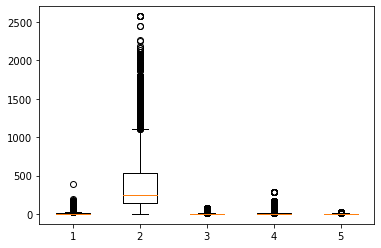

In [55]:
#연속형 변수들에 대해 boxplot 그리기
plt.boxplot(features.iloc[:,:5])
plt.show()

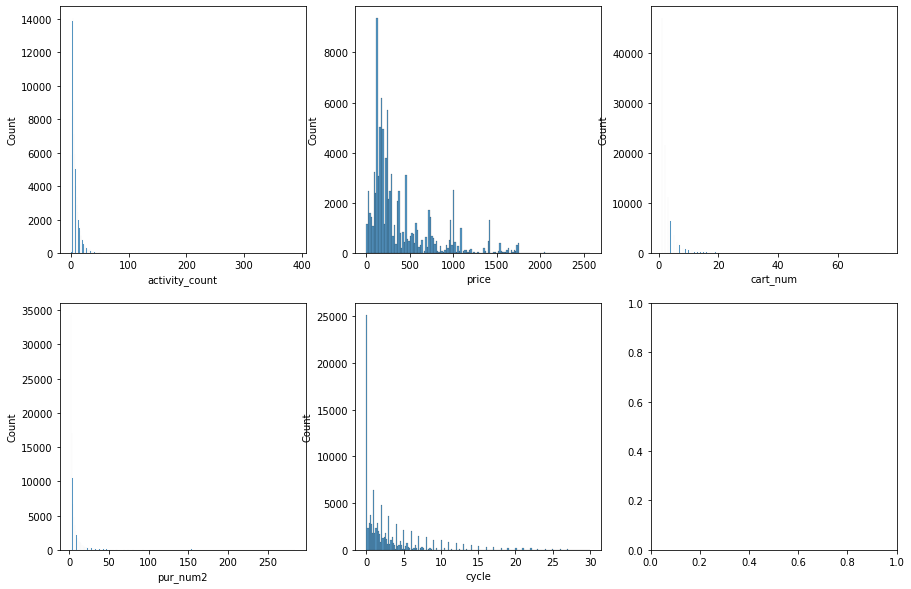

In [56]:
#연속형 변수들에 대해 histplot 그리기
import seaborn as sns
fig, axs = plt.subplots(2,3, figsize=(15,10)) 
X_df = features.iloc[:,:5]
lm_features=X_df.columns.tolist()
for i, feature in enumerate(lm_features):
    row=int(i/3)
    col=i%3
    sns.histplot(X_df[feature], ax=axs[row][col])

연속형 변수들의 스케일의 차이가 심하므로, 이는 좋은 성능을 기대할 수 없다. 변수들에 대해 왜곡 정도(skewness)를 계산해보자.

In [57]:
from scipy.stats import skew
feat = X_df.dtypes.index #피처명 반환
skew_feature = features[feat].apply(lambda x : skew(x)) #skew 정도를 반환

#여기서 skew가 1 이상인 피처 추출
skew_top = skew_feature[skew_feature > 1]
print(skew_top)

activity_count    4.700389
price             1.685665
cart_num          7.834875
pur_num2          7.257875
cycle             2.517445
dtype: float64


모든 연속형 변수들의 skew 정도가 심하므로, 이 변수들에 대해 로그변환

In [58]:
#skew가 1 이상인 피처에 대해 로그변환
features[skew_top.index] = np.log1p(features[skew_top.index])
#다시 skew 계산하면, 많이 줄었음을 알 수 있다.
skew(features.iloc[:,:5])

array([-0.08325679, -0.35790791,  1.63189819,  1.51816427,  0.53737354])

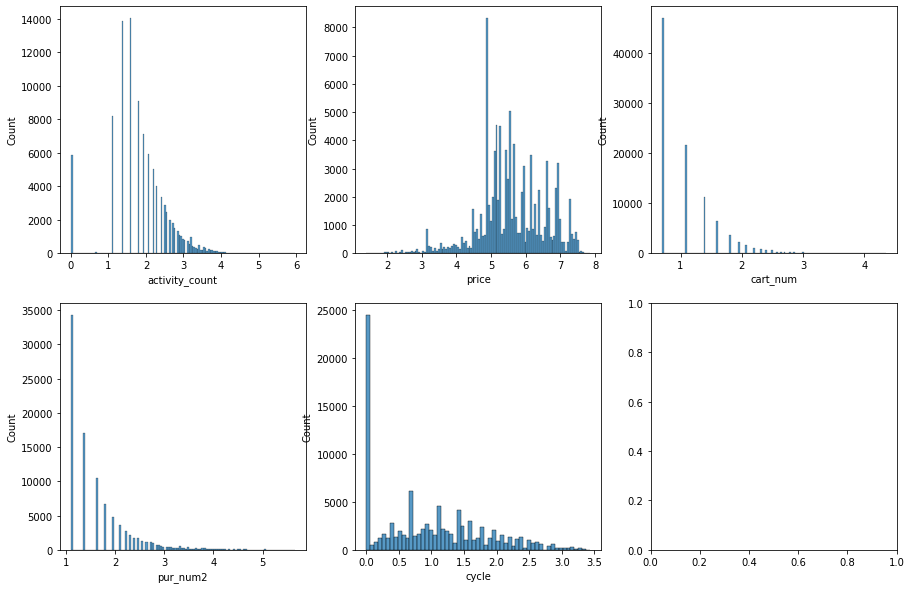

In [59]:
#다시 연속형 변수들에 대해 histplot 그리기
fig, axs = plt.subplots(2,3, figsize=(15,10))
X_df = features.iloc[:,:5]
lm_features=X_df.columns.tolist()
for i, feature in enumerate(lm_features):
    row=int(i/3)
    col=i%3
    sns.histplot(X_df[feature], ax=axs[row][col])

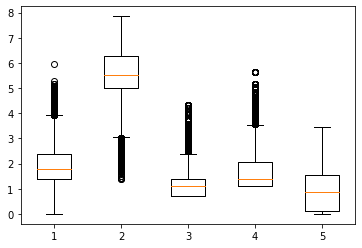

In [60]:
plt.boxplot(X_df)
plt.show()

왜곡 정도는 줄었으나, 아직도 스케일이 맞지 않아 표준화가 필요해 보임.(이건 추후 train/val/test set을 나눠 진행)

In [61]:
#타겟
is_purchased = downsampled['is_purchased']

### Model Training

In [62]:
# 크게 train_all & test set으로 나눔
X_train_all, X_test, y_train_all, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.2, 
                                                    random_state = 99)
# 다시 train_all을 학습을 위한 train set, 검증을 위한 validation set으로 나눔 
X_train, X_val, y_train, y_val = train_test_split(X_train_all, 
                                                    y_train_all, 
                                                    test_size = 0.2, 
                                                    random_state = 199)

In [63]:
print(X_train.shape, X_val.shape, X_test.shape)

(64000, 30) (16000, 30) (20000, 30)


In [64]:
X_train.head()

,activity_count,price,cart_num,pur_num2,cycle,event_weekday_0,event_weekday_1,event_weekday_2,event_weekday_3,event_weekday_4,...,category_code_level1_3,category_code_level1_4,category_code_level1_5,category_code_level1_6,category_code_level1_7,category_code_level1_8,category_code_level1_9,category_code_level1_10,category_code_level1_11,category_code_level1_12
58916,2.079442,5.853552,0.693147,1.609438,1.734601,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71924,2.302585,2.269028,0.693147,3.526361,0.318454,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
87219,2.079442,6.884036,0.693147,1.609438,1.791759,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
45906,2.397895,4.996874,0.693147,2.079442,1.734601,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
24582,1.609438,6.594660,1.609438,2.397895,1.021651,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [65]:
#X_train의 연속형 변수에 표준화 진행
train_con = X_train.iloc[:, :5]
train_mean = np.mean(train_con)
train_std = np.std(train_con)
print(train_mean)
print('')
print(train_std)

activity_count    1.906327
price             5.579284
cart_num          1.121368
pur_num2          1.734007
cycle             0.973488
dtype: float64

activity_count    0.801531
price             0.959350
cart_num          0.548302
pur_num2          0.749043
cycle             0.831138
dtype: float64


In [66]:
#X_train에서 연속형 변수만 떼서 표준화 후, 다시 merge
train_con_scaled = (train_con - train_mean)/train_std
train_con_scaled.rename(columns = {'activity_count':'ac_s', 'price':'price_s','cart_num':'cnum_s','pur_num2':'pnum_s','cycle':'cycle_s'}, inplace=True)
train_con_scaled.head()

,ac_s,price_s,cnum_s,pnum_s,cycle_s
58916,0.215980,0.285890,-0.780994,-0.166304,0.915748
71924,0.494377,-3.450518,-0.780994,2.392859,-0.788118
87219,0.215980,1.360038,-0.780994,-0.166304,0.984519
45906,0.613287,-0.607087,-0.780994,0.461168,0.915748
24582,-0.370402,1.058400,0.890148,0.886316,0.057948


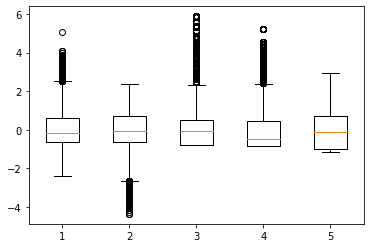

In [67]:
#boxplot 확인
plt.boxplot(train_con_scaled)
plt.show()

In [68]:
train_con_scaled.reset_index(inplace=True)
#이제 merge
X_train_new = X_train.reset_index()
X_train_scaled = pd.merge(X_train_new, train_con_scaled, on='index')
X_train_scaled

,index,activity_count,price,cart_num,pur_num2,cycle,event_weekday_0,event_weekday_1,event_weekday_2,event_weekday_3,...,category_code_level1_8,category_code_level1_9,category_code_level1_10,category_code_level1_11,category_code_level1_12,ac_s,price_s,cnum_s,pnum_s,cycle_s
0,58916,2.079442,5.853552,0.693147,1.609438,1.734601,1,0,0,0,...,0,0,0,0,0,0.215980,0.285890,-0.780994,-0.166304,0.915748
1,71924,2.302585,2.269028,0.693147,3.526361,0.318454,0,1,0,0,...,0,0,0,0,0,0.494377,-3.450518,-0.780994,2.392859,-0.788118
2,87219,2.079442,6.884036,0.693147,1.609438,1.791759,0,1,0,0,...,0,0,0,0,0,0.215980,1.360038,-0.780994,-0.166304,0.984519
3,45906,2.397895,4.996874,0.693147,2.079442,1.734601,0,0,1,0,...,0,0,0,0,0,0.613287,-0.607087,-0.780994,0.461168,0.915748
4,24582,1.609438,6.594660,1.609438,2.397895,1.021651,0,0,0,0,...,0,0,0,0,0,-0.370402,1.058400,0.890148,0.886316,0.057948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,86688,1.386294,6.544947,1.386294,2.079442,1.152680,0,1,0,0,...,0,0,0,0,0,-0.648798,1.006581,0.483176,0.461168,0.215598
63996,62952,2.564949,4.886809,0.693147,1.098612,1.098612,0,0,0,0,...,0,0,0,0,0,0.821706,-0.721816,-0.780994,-0.848276,0.150546
63997,47638,1.386294,4.824547,1.609438,1.386294,0.000000,0,0,0,0,...,0,0,0,0,0,-0.648798,-0.786717,0.890148,-0.464209,-1.171271
63998,26272,2.890372,5.527045,0.693147,2.197225,1.189584,0,0,0,0,...,0,0,0,0,0,1.227706,-0.054452,-0.780994,0.618413,0.260000


In [69]:
#기존의 index, price, activity_count 컬럼 제거
X_train_scaled.drop(['index','activity_count','price','cart_num','pur_num2','cycle'],axis=1, inplace=True)
X_train_scaled.head()

,event_weekday_0,event_weekday_1,event_weekday_2,event_weekday_3,event_weekday_4,event_weekday_5,event_weekday_6,event_week_1,event_week_2,event_week_3,...,category_code_level1_8,category_code_level1_9,category_code_level1_10,category_code_level1_11,category_code_level1_12,ac_s,price_s,cnum_s,pnum_s,cycle_s
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0.215980,0.285890,-0.780994,-0.166304,0.915748
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.494377,-3.450518,-0.780994,2.392859,-0.788118
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.215980,1.360038,-0.780994,-0.166304,0.984519
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.613287,-0.607087,-0.780994,0.461168,0.915748
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,-0.370402,1.058400,0.890148,0.886316,0.057948


In [70]:
#마찬가지로 val set에 대해서도 수행
#X_val에 대해 reset index
X_val_new = X_val.reset_index()

#X_val에서 연속형 변수만 떼서 표준화 후, 다시 merge
val_con = X_val.iloc[:, :5]
val_con_scaled = (val_con - train_mean)/train_std
val_con_scaled.rename(columns = {'activity_count':'ac_s', 'price':'price_s','cart_num':'cnum_s','pur_num2':'pnum_s','cycle':'cycle_s'}, inplace=True)
val_con_scaled.reset_index(inplace=True)
val_con_scaled.head()

,index,ac_s,price_s,cnum_s,pnum_s,cycle_s
0,16877,-0.648798,-0.450570,-0.041502,-0.464209,-1.171271
1,90691,0.049385,-2.554158,0.890148,-0.848276,-0.337298
2,21469,-0.648798,-2.400472,-0.041502,-0.464209,-0.337298
3,61805,1.156395,-0.721030,0.483176,-0.848276,1.169989
4,11589,-0.648798,-0.397382,-0.041502,0.077102,0.703441


In [71]:
#이제 merge
X_val_scaled = pd.merge(X_val_new, val_con_scaled, on='index')
#기존의 index, price, activity_count 컬럼 제거
X_val_scaled.drop(['index','activity_count','price','cart_num','pur_num2','cycle'],axis=1, inplace=True)
X_val_scaled.head()

,event_weekday_0,event_weekday_1,event_weekday_2,event_weekday_3,event_weekday_4,event_weekday_5,event_weekday_6,event_week_1,event_week_2,event_week_3,...,category_code_level1_8,category_code_level1_9,category_code_level1_10,category_code_level1_11,category_code_level1_12,ac_s,price_s,cnum_s,pnum_s,cycle_s
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,-0.648798,-0.450570,-0.041502,-0.464209,-1.171271
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.049385,-2.554158,0.890148,-0.848276,-0.337298
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,-0.648798,-2.400472,-0.041502,-0.464209,-0.337298
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1.156395,-0.721030,0.483176,-0.848276,1.169989
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,-0.648798,-0.397382,-0.041502,0.077102,0.703441


In [72]:
#XGBClassifier 모델 사용 
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.01, n_estimators=500, objective='binary:logistic')
model.fit(X_train_scaled, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
#val set에 대해 정확도 측정
y_pred = model.predict(X_val_scaled)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.6823125


### 모델 성능을 높이기 위한 하이퍼 파라미터 튜닝

In [74]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

# 객체 생성, 일단은 트리 100개만 만듦
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False)

# 후보 파라미터 선정
params = {'learning_rate':[0.001,0.01,0.1],
          'max_depth':[5,7,9],
          'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb_model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(X_train_scaled, y_train, early_stopping_rounds=30, eval_metric='logloss', eval_set=[(X_val_scaled, y_val)], verbose=0)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [75]:
#튜닝된 파라미터 출력
print(gridcv.best_params_)
print(gridcv.best_score_)

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9}
0.6959531517065911


In [76]:
#다시 적용해보기!
model = XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, 
                      max_depth=9, min_child_weight=1, 
                      n_estimators=1000, objective='binary:logistic')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)

[19:04:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.7315


validation set에 대한 정확도가 **약 73%** 까지 상승하였다! 그럼 Test set에 대해서도 진행해보자.

In [78]:
#Test set에 대해서 전처리
#X_test에 대해 reset index
X_test_new = X_test.reset_index()

#X_test에서 연속형 변수만 떼서 표준화 후, 다시 merge
test_con = X_test.iloc[:, :5]
test_con_scaled = (test_con - train_mean)/train_std
test_con_scaled.rename(columns = {'activity_count':'ac_s', 'price':'price_s','cart_num':'cnum_s','pur_num2':'pnum_s','cycle':'cycle_s'}, inplace=True)
test_con_scaled.reset_index(inplace=True)
test_con_scaled.head()

,index,ac_s,price_s,cnum_s,pnum_s,cycle_s
0,86155,-0.370402,1.360048,-0.780994,-0.848276,1.818493
1,29633,1.080759,0.348944,-0.780994,-0.848276,2.164623
2,67710,-0.142935,1.837793,-0.780994,-0.848276,1.914798
3,62348,-0.648798,0.025417,1.222668,-0.848276,2.306336
4,98787,0.049385,0.582894,0.890148,-0.848276,0.984519


In [79]:
#이제 merge
X_test_scaled = pd.merge(X_test_new, test_con_scaled, on='index')
#기존의 index, price, activity_count 컬럼 제거
X_test_scaled.drop(['index','activity_count','price','cart_num','pur_num2','cycle'],axis=1, inplace=True)
X_test_scaled.head()

,event_weekday_0,event_weekday_1,event_weekday_2,event_weekday_3,event_weekday_4,event_weekday_5,event_weekday_6,event_week_1,event_week_2,event_week_3,...,category_code_level1_8,category_code_level1_9,category_code_level1_10,category_code_level1_11,category_code_level1_12,ac_s,price_s,cnum_s,pnum_s,cycle_s
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,-0.370402,1.360048,-0.780994,-0.848276,1.818493
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1.080759,0.348944,-0.780994,-0.848276,2.164623
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-0.142935,1.837793,-0.780994,-0.848276,1.914798
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,-0.648798,0.025417,1.222668,-0.848276,2.306336
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0.049385,0.582894,0.890148,-0.848276,0.984519


### 최종 모델의 성능

In [80]:
#Test set에 대해 최종으로 만든 모델 적용
y_pred = model.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.73295


Test set에 대해 진행한 최종 모델의 정확도는 약 **73.3%** 로 측정되었다.  
이 이커머스 고객 정보 데이터에서, 고객의 정보로 활용할 수 있는 것이 구매주기, cart에 담은 횟수, purchase 횟수, activity count 등 다소 적은 정보였음에도 불구하고, 성능이 괜찮은 편이다.  
실제 기업의 이커머스 데이터를 다뤄보면 훨씬 더 폭넓은 고객의 정보 데이터로 분석할 수 있으므로, 다양한 피처를 만들어 고객의 재구매 예측 모델을 보다 더 정확하게 만들 수 있을 것이다.  

*특히 아쉬웠던 점* : cart에 담았던 기간은?(언제 cart에서 빠졌는지의 정보가 없어 만들지 못함), brand, category 등(원-핫 인코딩 시 너무 개수가 많아져 모델링 성능이 나빠져서 뺐다)의 좀 더 다양한 피처를 만들지 못했다는 점,  
2019년 10월의 데이터만을 바탕으로 하여, 시계열 분석을 적용하지 못했다는 점(왜냐면 이커머스 데이터는 seasonality가 존재하기 때문),  
데이터의 수가 좀 적어서 resample로 더 생성했다는 점(이는 전체 데이터의 4%만이 cart, purchase의 이벤트가 일어났고, 구매횟수가 1인 데이터가 많아 이런 것들은 제거 대상이었기 때문. 그리고 is_purchased의 1과 0의 개수도 차이가 많이 났다), 또 모델링에서 시간의 제약으로 인해 하이퍼 파라미터 튜닝을 더 다양하게 하지 못했단 점이다.

이커머스 데이터는 이번이 처음 다뤄보는 것인데, 힘들었지만 즐거운 경험이었다. :)

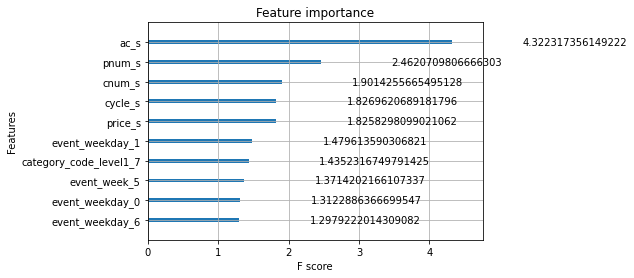

In [81]:
plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()

마지막으로 최종 모델에서 피처의 중요도를 나타내는 plot이다. 유의한 변수들은 ac_s, pnum_s, cnum_s, cycle_s, price_s의 연속형 변수들이 큰 중요도를 차지했으며, 특히 ac_s인 **activity count** 가 예상대로 가장 높은 중요도를 차지했다.  
그리고 원-핫 인코딩한 범주형 변수들(event_weekday, category_code_level1, event_week)도 뒤를 이었다.